In [1]:
import time
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pynq.overlays.base import BaseOverlay
from pynq.lib import Pmod_IO

In [2]:
# Load PYNQ Overlay
base = BaseOverlay("base.bit")

In [3]:
def toggle_pmod_pin(pmod_pin):
    pmod_pin.write(0) # Set the pin to low voltage
    time.sleep(0.25) # too fast will trigger lock screen
    pmod_pin.write(1) # Set the pin to high voltage
    
def mouse_click(pmod_pin, sleep_time=0):
    toggle_pmod_pin(pmod_pin)
    check_range_and_write_binary(0, pmod_io, pmod_io['pmod_iob0']) # without this will have bug
    if sleep_time > 0:
        time.sleep(sleep_time)
        toggle_pmod_pin(pmod_pin)
        check_range_and_write_binary(0, pmod_io, pmod_io['pmod_iob0']) # without this will have bug
 
def check_range_and_write_binary(num, pmod_io, pmod_pin):
    if num >= -128 and num <= 127:
        binary_num = bin(num & 0xFF)[2:].zfill(8)  # Convert the number to 8-bit binary string
        binary_num = binary_num[::-1]  # Reverse the binary string
        for i in range(8):
            pmod_io[f'pmod_ioa{i}'].write(int(binary_num[i]))
        toggle_pmod_pin(pmod_pin)
        
def split_and_write_binary(value, pmod_io, pmod_io_channel):
    sign = 1 if value >= 0 else -1
    value *= sign
    while value > 100:
        check_range_and_write_binary(100 * sign, pmod_io, pmod_io_channel)
        value -= 100
    check_range_and_write_binary(value * sign, pmod_io, pmod_io_channel)

In [4]:
# Initialize the digital signal pins of PMOD module
pmod_io = {}

for i in range(8):
    pmod_io[f'pmod_ioa{i}'] = Pmod_IO(base.PMODA, i, 'out')

for i in range(3):
    pmod_io[f'pmod_iob{i}'] = Pmod_IO(base.PMODB, i, 'out')
    
for i in range(8):
    pmod_io[f'pmod_ioa{i}'].write(0) # Set the pins to low voltage
    
for i in range(3):
    pmod_io[f'pmod_iob{i}'].write(1) # Set the pins to high voltage

In [5]:
#Initialize first_turn detection picture
# Round 1   1 左1                 3 左2              5 中3                6 從者         8 右3                 9 從者           11 attack           12 寶具
Coordinate = [(235,770),(345,770),(840,770),(517,498),(1223,770),(517,498),(1463,790),(606,273)]

FirstTurnPictureList=[]

folder_path = './process_gray/first_turn'

# Get the list of file names and sort them
file_names = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))

for file_name in file_names:
    print(f"Processing file: {file_name}")  # Print the file name
    image = cv2.imread(os.path.join(folder_path, file_name))
    h, w, _ = image.shape # Get the dimensions of the template
    grayscale = np.ndarray(shape=(h, w),dtype=np.uint8)
    cv2.cvtColor(image,cv2.COLOR_BGR2GRAY,dst=grayscale)
    
    if grayscale is not None:
        FirstTurnPictureList.insert(-1,grayscale)
    else:
        print(f"Failed to load {file_name}")

Processing file: 1.png
Processing file: 2.png
Processing file: 3.png
Processing file: 4.png
Processing file: 5.png
Processing file: 6.png
Processing file: 7.png
Processing file: 8.png


In [6]:
#Initailize hdmi in
hdmi_in = base.video.hdmi_in
hdmi_in.configure()
hdmi_in.start()

In [7]:
def cv2_object_detect(step, left, top, template, threshold):
    for i in range(10):
        # inframe contains the whole image
        inframe = hdmi_in.readframe()
        grayscale = np.ndarray(shape=(hdmi_in.mode.height, hdmi_in.mode.width),dtype=np.uint8)
        cv2.cvtColor(inframe,cv2.COLOR_BGR2GRAY,dst=grayscale)

        # template contains the image you want to detect

        # Get the dimensions of the template
        h, w = template.shape
        print(f"Template Height: {h}, Template Width: {w}")

        cropped_image = grayscale[top:top+h, left:left+w]
        
        # Display the cropped image
        plt.imshow(cropped_image, cmap='gray')
        plt.show()

        h, w = cropped_image.shape
        print(f"Cropped image height: {h}, Cropped image width: {w}")

        # Apply template matching
        res = cv2.matchTemplate(cropped_image, template, cv2.TM_CCORR_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        if(max_val >= threshold):
            print(f"Step {step} succeeded with similarity {max_val}")      
            return
        else:
            print(f"Attempt {i+1} failed with similarity {max_val}. Trying again...")
            time.sleep(0.5)  # Wait for half second before the next attempt
                   
    input("Detection failed after 5 attempts. Press Enter to continue...")  
    return

In [8]:
# Initialize mouse position
split_and_write_binary(-500, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
check_range_and_write_binary(50, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
split_and_write_binary(-500, pmod_io, pmod_io['pmod_iob1']) # Move cursor up 
check_range_and_write_binary(50, pmod_io, pmod_io['pmod_iob1']) # Move cursor down

Starting round 1
Template Height: 70, Template Width: 70


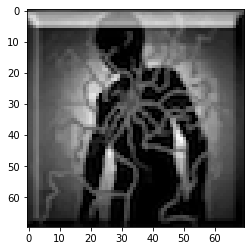

Cropped image height: 70, Cropped image width: 70
Step 1 succeeded with similarity 0.7682153582572937
Template Height: 70, Template Width: 65


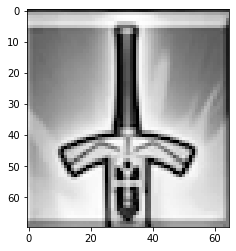

Cropped image height: 70, Cropped image width: 65
Step 2 succeeded with similarity 0.8651999235153198
Template Height: 63, Template Width: 109


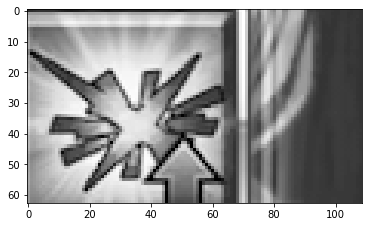

Cropped image height: 63, Cropped image width: 109
Step 3 succeeded with similarity 0.8768859505653381
Template Height: 70, Template Width: 65


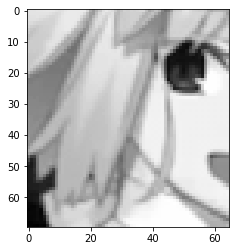

Cropped image height: 70, Cropped image width: 65
Step 4 succeeded with similarity 0.8816810846328735
Template Height: 63, Template Width: 109


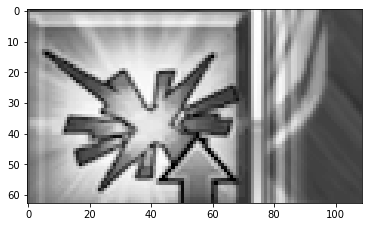

Cropped image height: 63, Cropped image width: 109
Step 5 succeeded with similarity 0.894539475440979
Template Height: 78, Template Width: 207


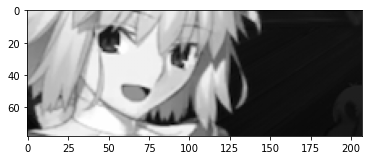

Cropped image height: 78, Cropped image width: 207
Step 6 succeeded with similarity 0.7355682849884033
Template Height: 203, Template Width: 151


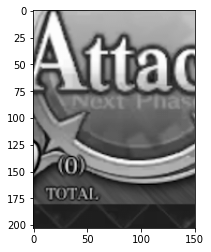

Cropped image height: 203, Cropped image width: 151
Step 7 succeeded with similarity 0.8474600911140442
Template Height: 70, Template Width: 70


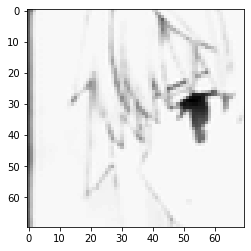

Cropped image height: 70, Cropped image width: 70
Step 8 succeeded with similarity 0.7923281192779541


In [9]:
print("Starting round 1")

# Move to servant 1, skill 1
step = 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
check_range_and_write_binary(-36, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
split_and_write_binary(140, pmod_io, pmod_io['pmod_iob1']) # Move cursor down
mouse_click(pmod_io['pmod_iob2'], 0.1)
time.sleep(1)

# Move to servant 1, skill 2
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
check_range_and_write_binary(32, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
mouse_click(pmod_io['pmod_iob2'], 0.1)
time.sleep(1)

# Move to servant 2, skill 3
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
check_range_and_write_binary(100, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
check_range_and_write_binary(26, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.25)

# Select servant 1
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
check_range_and_write_binary(-60, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
check_range_and_write_binary(-50, pmod_io, pmod_io['pmod_iob1']) # Move cursor up
mouse_click(pmod_io['pmod_iob2'], 0.1)
time.sleep(1)

# Move to servant 3, skill 3
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
split_and_write_binary(154, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
check_range_and_write_binary(50, pmod_io, pmod_io['pmod_iob1']) # Move cursor down
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.25)

# Select servant 1
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
split_and_write_binary(-155, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
check_range_and_write_binary(-50, pmod_io, pmod_io['pmod_iob1']) # Move cursor up
mouse_click(pmod_io['pmod_iob2'], 0.1)
time.sleep(1)

# Move to Attack button
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
split_and_write_binary(233, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
check_range_and_write_binary(56, pmod_io, pmod_io['pmod_iob1']) # Move cursor down
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(1)

# Move to servant 1 noble phantasm
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
split_and_write_binary(-210, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
split_and_write_binary(-127, pmod_io, pmod_io['pmod_iob1']) # Move cursor up
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.5)

# Move to command card 2
check_range_and_write_binary(-10, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
check_range_and_write_binary(80, pmod_io, pmod_io['pmod_iob1']) # Move cursor down
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.5)

# Move to command card 3
check_range_and_write_binary(64, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.5)

# Wait noble phantasm
time.sleep(25)

In [10]:
#Initialize second turn detection pictures
# Round 2   1 中1                 2 從者         4 右1                  5. 從者         9. attack          10 寶具
Coordinate=[(620,770),(517,498),(1005,770),(517,498),(1463,790),(606,273)]
SecondTurnPictureList=[]
folder_path = './process_gray/second_turn'

# Get the list of file names and sort them
file_names = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))

for file_name in file_names:
    print(f"Processing file: {file_name}")  # Print the file name
    image = cv2.imread(os.path.join(folder_path, file_name))
    h, w, _ = image.shape # Get the dimensions of the template
    grayscale = np.ndarray(shape=(h, w),dtype=np.uint8)
    cv2.cvtColor(image,cv2.COLOR_BGR2GRAY,dst=grayscale)
    
    if grayscale is not None:
        FirstTurnPictureList.insert(-1,grayscale)
    else:
        print(f"Failed to load {file_name}")

Processing file: 1.png
Processing file: 2.png
Processing file: 3.png
Processing file: 4.png
Processing file: 5.png
Processing file: 6.png


Starting round 2
Template Height: 70, Template Width: 70


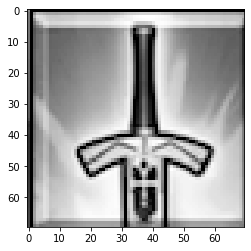

Cropped image height: 70, Cropped image width: 70
Step 1 succeeded with similarity 0.921583354473114
Template Height: 70, Template Width: 65


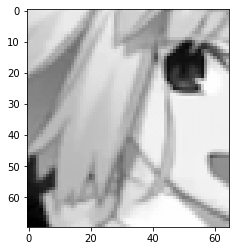

Cropped image height: 70, Cropped image width: 65
Step 2 succeeded with similarity 0.8815382122993469
Template Height: 63, Template Width: 109


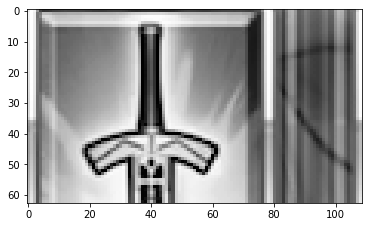

Cropped image height: 63, Cropped image width: 109
Step 3 succeeded with similarity 0.8905702233314514
Template Height: 70, Template Width: 65


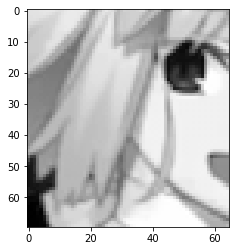

Cropped image height: 70, Cropped image width: 65
Step 4 succeeded with similarity 0.881260335445404
Template Height: 63, Template Width: 109


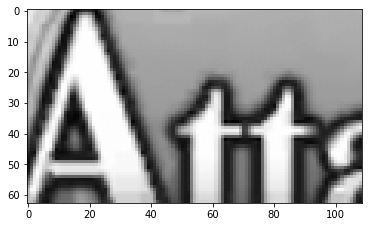

Cropped image height: 63, Cropped image width: 109
Step 5 succeeded with similarity 0.8933491706848145
Template Height: 78, Template Width: 207


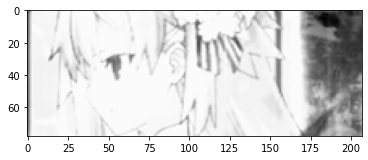

Cropped image height: 78, Cropped image width: 207
Step 6 succeeded with similarity 0.9016765356063843


In [11]:
print("Starting round 2")

# Move to servant 2, skill 1
step = 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
check_range_and_write_binary(-62, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
check_range_and_write_binary(29, pmod_io, pmod_io['pmod_iob1']) # Move cursor down
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.25)

# Select servant 1
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
check_range_and_write_binary(-25, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
check_range_and_write_binary(-52, pmod_io, pmod_io['pmod_iob1']) # Move cursor up
mouse_click(pmod_io['pmod_iob2'], 0.1)
time.sleep(1)

# Move to servant 3, skill 1
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
split_and_write_binary(108, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
check_range_and_write_binary(53, pmod_io, pmod_io['pmod_iob1']) # Move cursor down
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.25)

# Select servant 1
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
split_and_write_binary(-110, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
check_range_and_write_binary(-52, pmod_io, pmod_io['pmod_iob1']) # Move cursor up
mouse_click(pmod_io['pmod_iob2'], 0.1)
time.sleep(1)

# Move to Attack button
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
split_and_write_binary(233, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
check_range_and_write_binary(56, pmod_io, pmod_io['pmod_iob1']) # Move cursor down
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(1)

# Move to servant 1 noble phantasm
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
split_and_write_binary(-210, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
split_and_write_binary(-127, pmod_io, pmod_io['pmod_iob1']) # Move cursor up
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.5)

# Move to command card 2
check_range_and_write_binary(-10, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
check_range_and_write_binary(80, pmod_io, pmod_io['pmod_iob1']) # Move cursor down
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.5)

# Move to command card 3
check_range_and_write_binary(64, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.5)

# Wait noble phantasm
time.sleep(25)

In [12]:
#Initialize thid turn detection pictures
# Round 3   1 御主魔術禮裝         2御主魔術禮裝技能三  3 從者            4 左1              5 左2              9. attack          10 寶具
Coordinate=[(1596,450),(1460,440),(517,498),(235,770),(345,770),(1463,790),(606,273)]
ThirdTurnPictureList=[]
folder_path = './process_gray/third_turn'

# Get the list of file names and sort them
file_names = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))

for file_name in file_names:
    print(f"Processing file: {file_name}")  # Print the file name
    image = cv2.imread(os.path.join(folder_path, file_name))
    h, w, _ = image.shape # Get the dimensions of the template
    grayscale = np.ndarray(shape=(h, w),dtype=np.uint8)
    cv2.cvtColor(image,cv2.COLOR_BGR2GRAY,dst=grayscale)
    
    if grayscale is not None:
        FirstTurnPictureList.insert(-1,grayscale)
    else:
        print(f"Failed to load {file_name}")

Processing file: 1.png
Processing file: 2.png
Processing file: 3.png
Processing file: 4.png
Processing file: 5.png
Processing file: 6.png
Processing file: 7.png


Starting round 3
Template Height: 70, Template Width: 70


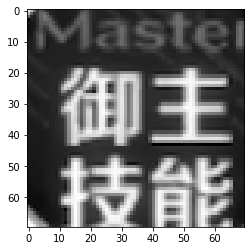

Cropped image height: 70, Cropped image width: 70
Step 1 succeeded with similarity 0.790224015712738
Template Height: 70, Template Width: 65


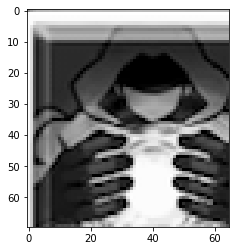

Cropped image height: 70, Cropped image width: 65
Step 2 succeeded with similarity 0.7216463685035706
Template Height: 63, Template Width: 109


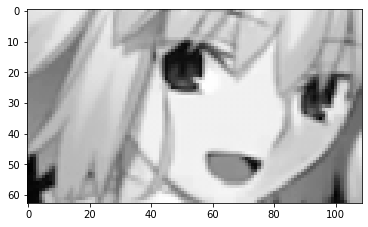

Cropped image height: 63, Cropped image width: 109
Step 3 succeeded with similarity 0.9987914562225342
Template Height: 70, Template Width: 65


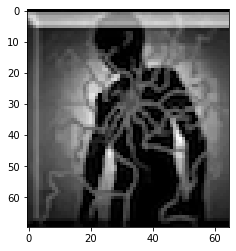

Cropped image height: 70, Cropped image width: 65
Step 4 succeeded with similarity 0.7781436443328857
Template Height: 63, Template Width: 109


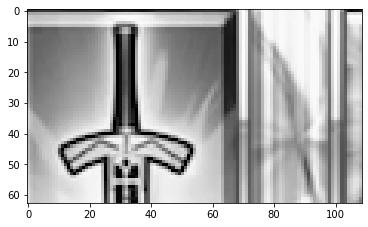

Cropped image height: 63, Cropped image width: 109
Step 5 succeeded with similarity 0.9068392515182495
Template Height: 78, Template Width: 207


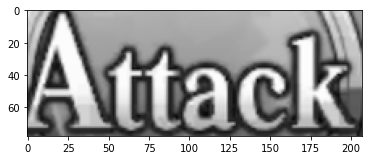

Cropped image height: 78, Cropped image width: 207
Step 6 succeeded with similarity 0.9728273153305054
Template Height: 203, Template Width: 151


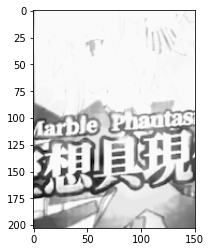

Cropped image height: 203, Cropped image width: 151
Step 7 succeeded with similarity 0.972950279712677


In [13]:
print("Starting round 3")

# Move to mystic code
step = 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
split_and_write_binary(151, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
check_range_and_write_binary(-52, pmod_io, pmod_io['pmod_iob1']) # Move cursor up
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.25)

# Move to mystic code skill 3
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
check_range_and_write_binary(-36, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.25)

# Select servant 1
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
split_and_write_binary(-220, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
check_range_and_write_binary(30, pmod_io, pmod_io['pmod_iob1']) # Move cursor down
mouse_click(pmod_io['pmod_iob2'], 0.1)
time.sleep(1)

# Move to servant 1, skill 1
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
check_range_and_write_binary(-66, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
check_range_and_write_binary(52, pmod_io, pmod_io['pmod_iob1']) # Move cursor down
mouse_click(pmod_io['pmod_iob2'], 0.1)
time.sleep(1)

# Move to servant 1, skill 2
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
check_range_and_write_binary(33, pmod_io, pmod_io['pmod_iob0'])
mouse_click(pmod_io['pmod_iob2'], 0.1)
time.sleep(1)

# Move to Attack button
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
split_and_write_binary(265, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
check_range_and_write_binary(16, pmod_io, pmod_io['pmod_iob1']) # Move cursor down
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(1)

# Move to servant 1 noble phantasm
step += 1
cv2_object_detect(step, Coordinate[step-1][0], Coordinate[step-1][1], FirstTurnPictureList[step-1], 0.7)
split_and_write_binary(-210, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
split_and_write_binary(-127, pmod_io, pmod_io['pmod_iob1']) # Move cursor up
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.5)

# Move to command card 2
check_range_and_write_binary(-10, pmod_io, pmod_io['pmod_iob0']) # Move cursor left
check_range_and_write_binary(80, pmod_io, pmod_io['pmod_iob1']) # Move cursor down
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.5)

# Move to command card 3
check_range_and_write_binary(64, pmod_io, pmod_io['pmod_iob0']) # Move cursor right
mouse_click(pmod_io['pmod_iob2'], 0)
time.sleep(0.5)

# Wait noble phantasm
time.sleep(25)

In [14]:
# Finally you must always stop the interfaces when you are done with them.
# Otherwise bad things can happen when the bitstream is reprogrammed.
hdmi_in.close()